# Setup

In [ ]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from tqdm import tqdm
import networkx as nx
#import igraph as ig
import random
import csv
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
# Visualization Libraries
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.models import Circle, Legend, LegendItem, MultiLine
from bokeh.models.graphs import NodesAndLinkedEdges
from bokeh.palettes import Blues256, Blues8, Greens256, Oranges256, Turbo256
from bokeh.plotting import figure, from_networkx
from IPython.display import Audio, clear_output, display

In [ ]:
!pip install python-louvain
import community.community_louvain as community_louvain

In [ ]:
!pip install infomap
import infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.7.1-cp310-cp310-linux_x86_64.whl size=7690305 sha256=17ec093426956f9b4f376a748d3b1743c00514a3a7f540d67b19d6d728cd8234
  Stored in directory: /root/.cache/pip/wheels/e4/01/53/fd7c62079098140cd582b999592b4592c0dad7300cac32b6e1
Successfully built infomap


In [ ]:
!pip install leidenalg
import leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.7 MB/s eta 0:00:00


In [ ]:
def calculate_time_taken(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        try:
            result = func(*args, **kwargs)
        except Exception as e:
            playErrorSound()
            print(f"An error occurred: {e}")
            raise  # Re-lança a exceção para que o código chamador possa lidar com ela se necessário
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken: {elapsed_time:.2f} seconds")
        playSound()
        return result
    return wrapper
##
def find_and_print_user_by_id(df, user_id):
    user_row = df[df['colab_user_id'] == user_id]
    if not user_row.empty:
        print(user_row)
    else:
        print(f"No row found with colab_user_id {user_id}")
###
# Play a sound
def playSound():
    sound_file = 'https://freesound.org/data/previews/80/80921_1022651-lq.mp3'
    try:
      display(Audio(sound_file, autoplay=True))
    except Exception as e:
      print("error playing sound lmao")
####
# Play a sound
def playErrorSound():
    sound_file = 'https://cdn.freesound.org/previews/450/450616_9159316-lq.mp3'
    display(Audio(sound_file, autoplay=True))
####

# Load Data

In [ ]:
comments_url = "https://drive.usercontent.google.com/download?id=18vF-9KzvBH1NDnepzVpEKEsHqJnSrZu-&export=download&authuser=3&confirm=t&uuid=16516fb9-e9fa-4f21-9e52-a771b33787c3&at=APZUnTULRxOxdxsScK9nILnflb3q:1694052463506"
# read csv file
colab_comments = pd.read_csv(comments_url, sep=',', decimal='.', header=0, low_memory=False)
print(colab_comments.columns)
print(colab_comments.head(1))
colab_comments

Index(['id', 'created_at', 'colab_user_id_from', 'colab_user_id_to',
       'event_type_id', 'event_id'],
      dtype='object')
     id                created_at  colab_user_id_from  colab_user_id_to  \
0  7175  2014-05-04T00:14:40-0300               32595             28560   

   event_type_id  event_id  
0           1181      6252  


,id,created_at,colab_user_id_from,colab_user_id_to,event_type_id,event_id
0,7175,2014-05-04T00:14:40-0300,32595,28560,1181,6252
1,11259,2014-07-24T13:45:28-0300,40434,40434,3949,8509
2,12165,2014-08-08T12:06:55-0300,41132,40544,60,8464
3,10590,2014-07-09T17:59:25-0300,36998,36998,3920,8039
4,7443,2014-05-07T21:49:46-0300,32968,32065,3940,6370
...,...,...,...,...,...,...
334677,33749,2015-03-08T21:56:35-0300,75404,63081,1190,18222
334678,119668,2016-03-10T19:05:41-0300,114778,114778,4973,50642
334679,25352,2015-01-11T20:06:05-0200,63405,62718,1214,14446
334680,25354,2015-01-11T20:12:23-0200,63405,62535,1214,14389


In [ ]:
likes_url = "https://drive.usercontent.google.com/download?id=1jBjbR_jZQZNsMdpk9e5UuOlfSoMGPIsm&export=download&authuser=3&confirm=t&uuid=16516fb9-e9fa-4f21-9e52-a771b33787c3&at=APZUnTULRxOxdxsScK9nILnflb3q:1694052463506"
# read csv file
colab_likes = pd.read_csv(likes_url, sep=',', decimal='.', header=0, low_memory=False)
print(colab_likes.columns)
print(colab_likes.head(1))
colab_likes

Index(['id', 'created_at', 'colab_user_id_from', 'colab_user_id_to',
       'event_type_id', 'event_id'],
      dtype='object')
      id                created_at  colab_user_id_from  colab_user_id_to  \
0  21262  2014-05-11T01:39:04-0300               29163             27334   

   event_type_id  event_id  
0           1214      6456  


,id,created_at,colab_user_id_from,colab_user_id_to,event_type_id,event_id
0,21262,2014-05-11T01:39:04-0300,29163,27334,1214,6456
1,20696,2014-05-08T11:41:22-0300,32994,14375,3920,6394
2,20814,2014-05-08T23:51:51-0300,32092,32092,7575,6401
3,21258,2014-05-11T01:22:15-0300,33018,33018,1363,6428
4,21277,2014-05-11T04:01:42-0300,32977,3699,7586,6463
...,...,...,...,...,...,...
1048570,1223098,2021-11-24T21:59:42-0300,186310,186310,9954,329797
1048571,1302647,2022-02-08T15:04:38-0300,186310,231120,9908,173883
1048572,1307278,2022-02-11T17:07:36-0300,415276,268969,9926,349198
1048573,1307563,2022-02-11T17:28:34-0300,415276,264351,432,336844


In [ ]:
updown_url = "https://drive.usercontent.google.com/download?id=1eM6AwfPYlmfrqQOuop9Im46AedYe_E93&export=download&authuser=3&confirm=t&uuid=eed60c3f-bce1-46cd-83eb-a9c33bd55df9&at=APZUnTVojRNJK9ALj7DRZ_D5is--:1694050615548"
colab_updown = pd.read_csv(updown_url)
print(colab_updown.columns)
print(colab_updown.head(1))
colab_updown

Index(['id', 'created_at', 'colab_user_id_from', 'colab_user_id_to',
       'event_id', 'event_type_id', 'colab_user_event', 'comment_id', 'vote'],
      dtype='object')
   id                created_at  colab_user_id_from  colab_user_id_to  \
0  28  2021-08-04T21:02:21-0300              236585               NaN   

   event_id  event_type_id  colab_user_event  comment_id vote  
0  300071.0         1689.0           76184.0      849707   UP  


,id,created_at,colab_user_id_from,colab_user_id_to,event_id,event_type_id,colab_user_event,comment_id,vote
0,28,2021-08-04T21:02:21-0300,236585,NaN,300071.0,1689.0,76184.0,849707,UP
1,35,2021-08-05T00:43:11-0300,323968,313537.0,217188.0,3353.0,313537.0,591072,UP
2,50,2021-08-05T00:44:51-0300,323968,429282.0,217188.0,3353.0,313537.0,836739,UP
3,76,2021-08-05T16:55:47-0300,202266,NaN,153045.0,7578.0,202266.0,416256,UP
4,89,2021-08-05T21:27:10-0300,222051,222051.0,164113.0,3332.0,222051.0,838576,UP
...,...,...,...,...,...,...,...,...,...
58680,35344,2022-06-02T01:23:08-0300,227897,NaN,378589.0,3327.0,227897.0,1074711,UP
58681,35347,2022-06-02T02:32:44-0300,116186,262480.0,NaN,NaN,NaN,1027219,DOWN
58682,35350,2022-06-02T03:03:05-0300,688906,689179.0,376664.0,11652.0,689179.0,1068924,UP
58683,35351,2022-06-02T03:20:54-0300,688906,NaN,377119.0,11652.0,684855.0,1070466,UP


In [ ]:
events_url = "spider_df.csv"
events = pd.read_csv(events_url, sep=',', decimal='.', header=0)
print(events.head())
print(events.columns)
events

   Unnamed: 0  event_id  colab_user_id     persona  persona_value  \
0           0        41             86      helper            0.0   
1           1        54              2  complainer            1.0   
2           2        58             86      helper            0.0   
3           3       582             86      helper            0.0   
4           4       918             86      helper            0.0   

                                         description    score  event_type_id  \
0                        Árvore bloqueando a calçada -0.03574           7574   
1  Barraca no meio da calçada na Marquês de Olind... -0.03217           7558   
2  Utilização da calçada para estacionamento. Pad... -0.04684           7558   
3  Árvore batendo na fiação, que já está toda bag... -0.13990           3942   
4  Entulho na calçada e o pedestre tem que passar... -0.19282           3938   

                      event_type_name  
0                      Poda de árvore  
1  Ocupação irregular de

,Unnamed: 0,event_id,colab_user_id,persona,persona_value,description,score,event_type_id,event_type_name
0,0,41,86,helper,0.0,Árvore bloqueando a calçada,-0.03574,7574,Poda de árvore
1,1,54,2,complainer,1.0,Barraca no meio da calçada na Marquês de Olind...,-0.03217,7558,Ocupação irregular de área pública
2,2,58,86,helper,0.0,Utilização da calçada para estacionamento. Pad...,-0.04684,7558,Ocupação irregular de área pública
3,3,582,86,helper,0.0,"Árvore batendo na fiação, que já está toda bag...",-0.13990,3942,Poda de árvore
4,4,918,86,helper,0.0,Entulho na calçada e o pedestre tem que passar...,-0.19282,3938,Entulho na calçada/via pública
...,...,...,...,...,...,...,...,...,...
132853,132853,258206,293209,complainer,1.0,Vizinho fez uma reforma na casa e simplesmente...,-0.63388,9,Entulho na calçada/via pública
132854,132854,274342,319241,complainer,1.0,"Porque não coloca GCM, uma Base nessa praça? ...",-0.08944,56,Ponto de exploração sexual de menores
132855,132855,285040,197268,helper,0.0,"Olá, no telhado do imóvel localizado na avenid...",-0.12818,54,Infestação animais perigosos
132856,132856,284833,95084,helper,0.0,"Boa tarde, no sambaqui de Balneario arroio do ...",0.40797,46,Mato alto


In [ ]:
# 1. Obter os IDs únicos de event_id do dataframe events.
unique_event_ids = events['event_id'].unique()

# 2. Filtrar cada um dos outros dataframes.

# Filtrar colab_comments
colab_comments = colab_comments[colab_comments['event_id'].isin(unique_event_ids)]

# Filtrar colab_likes
colab_likes = colab_likes[colab_likes['event_id'].isin(unique_event_ids)]

# Filtrar colab_updown
colab_updown = colab_updown[colab_updown['event_id'].isin(unique_event_ids)]

print("Número de linhas em filtered_colab_comments:", colab_comments.shape[0])
print("Número de linhas em filtered_colab_likes:", colab_likes.shape[0])
print("Número de linhas em filtered_colab_updown:", colab_updown.shape[0])

Número de linhas em filtered_colab_comments: 101867
Número de linhas em filtered_colab_likes: 232267
Número de linhas em filtered_colab_updown: 13744


In [ ]:
url_edges = "https://drive.google.com/uc?id=1skMWv0IDbMZ-Gl3f2BzCVScmK6cZPakd&export=download" # gephi
edges = pd.read_csv(url_edges, sep=',', decimal='.', header=0)
edges

,source,target
0,113450,162519
1,113450,118923
2,113450,40367
3,113450,123242
4,113450,39850
...,...,...
25780,248233,58898
25781,248233,60405
25782,321685,284896
25783,321685,291751


In [ ]:
url_nodes = "https://drive.google.com/uc?id=1C04iiMkjoWStAbL19RcIAAE2uOnITejr&export=download"
nodes = pd.read_csv(url_nodes, sep=',', decimal='.', header=0)
nodes = nodes[nodes['colab_user_id'].isin(edges['source']) | nodes['colab_user_id'].isin(edges['target'])]
nodes

,colab_user_id,birth_date,city,education,gender,idade,race
0,323968,1969-08-11,Santo André,bachelor,female,54.0,white
1,222051,1961-02-12,Santo André,primary,male,62.0,NaN
3,355872,1996-05-02,Niterói,unfinished_bachelor,female,27.0,white
9,43311,1975-06-18,Niterói,bachelor,male,48.0,white
26,236585,1959-02-07,Niterói,primary,female,64.0,white
...,...,...,...,...,...,...,...
56925,339868,2021-03-19,Santo André,bachelor,male,2.0,NaN
57023,467302,1997-01-30,Niterói,unfinished_bachelor,female,26.0,NaN
57251,213426,NaN,Niterói,NaN,NaN,NaN,NaN
57337,251594,NaN,Niterói,NaN,NaN,NaN,NaN


# Heuristics

In [ ]:
def get_unique_event_types_for_user_from_df(user_id, dataframe):
    return dataframe[dataframe['colab_user_id_from'] == user_id]['event_type_id'].unique()

def get_all_unique_event_types_for_user(user_id):
    # Get from events df
    event_types_from_events = events[events['colab_user_id'] == user_id]['event_type_id'].unique()

    # Get from colab_comments df
    event_types_from_comments = get_unique_event_types_for_user_from_df(user_id, colab_comments)

    # Get from colab_likes df
    event_types_from_likes = get_unique_event_types_for_user_from_df(user_id, colab_likes)

    # Get from colab_updown df
    event_types_from_updown = get_unique_event_types_for_user_from_df(user_id, colab_updown)

    # Combine all unique event types
    all_event_types = np.concatenate([event_types_from_events, event_types_from_comments, event_types_from_likes, event_types_from_updown])

    return np.unique(all_event_types)

In [ ]:
def get_all_scores_for_user(user_id):
    # Get scores from events df
    scores_from_events = events[events['colab_user_id'] == user_id]['score'].values

    # Get scores from colab_updown df (considering downvotes as negative scores and upvotes as positive scores)
    updown_votes = colab_updown[colab_updown['colab_user_id_from'] == user_id]
    scores_from_updown = np.where(updown_votes['vote'] == 'down', -1, 1)

    #print(updown_votes)
    #print(scores_from_updown)

    # Combine all scores
    all_scores = np.concatenate([scores_from_events, scores_from_updown])

    return all_scores

def get_persona_for_user(user_id):
    # Filtrar eventos para o user_id específico
    user_events = events[events['colab_user_id'] == user_id]

    # Verificar se existem registros para o user_id
    if not user_events.empty:
        return user_events['persona'].iloc[0]
    else:
        return None  # ou qualquer outro valor padrão que você desejar

In [ ]:
def calculate_community_ecc(G, community):
    # Extract scores of posts and interactions from community members
    scores = [get_all_scores_for_user(member) for member in community]
    #print("scores", scores)

    # Flatten the list of scores
    all_scores = [score for sublist in scores for score in sublist]

    # Check if the list is not empty and does not contain only NaNs
    if not all_scores or np.all(np.isnan(all_scores)):
        return 0

    # Calculate standard deviation of scores
    ecc = np.nanstd(all_scores)  # Use nanstd to ignore NaNs

    return ecc

def calculate_community_gec(G, community):
    # Extract scores of posts and interactions from community members
    scores = [get_all_scores_for_user(member) for member in community]

    # Flatten the list of scores
    all_scores = [score for sublist in scores for score in sublist]

    # Check if the list is not empty and does not contain only NaNs
    if not all_scores or np.all(np.isnan(all_scores)):
        return 0

    # Calculate the product of signs of scores
    gec = np.nansum(np.sign(all_scores))  # Use nansum to ignore NaNs

    return gec


In [ ]:
def calculate_community_homogeneity(G, community):
    # Get unique event types for the community members
    community_event_types = [get_all_unique_event_types_for_user(member) for member in community]

    # Flatten the list of event types for community members
    all_community_event_types = [event_type for sublist in community_event_types for event_type in sublist]

    # If the list is empty, return 0 for homogeneity
    if not all_community_event_types:
        return 0

    # Calculate the proportion of community's event types that are also in other community members' event types
    common_event_types = set(all_community_event_types).intersection(all_community_event_types)
    event_type_ratio = len(common_event_types) / len(all_community_event_types)

    # Get personas for the community members
    community_personas = [get_persona_for_user(member) for member in community]

    # Calculate the proportion of community members with the same persona
    common_persona_count = community_personas.count(community_personas[0])
    persona_ratio = common_persona_count / len(community)

    # Combine the two ratios to get an overall homogeneity ratio
    homogeneity_ratio = (event_type_ratio + persona_ratio) / 2

    return homogeneity_ratio


In [ ]:
def calculate_community_exposure(community):
    # Obtenha todos os event_type_ids únicos com os quais a comunidade interagiu
    all_community_event_types = set()
    for member in community:
        member_event_types = get_all_unique_event_types_for_user(member)
        all_community_event_types.update(member_event_types)

    total_community_event_types = len(all_community_event_types)

    # Se a comunidade não interagiu com nenhum tipo de evento, a exposição é 0
    if total_community_event_types == 0:
        return 0

    # Calcule a exposição para cada membro da comunidade
    individual_exposures = []
    for member in community:
        member_event_types = get_all_unique_event_types_for_user(member)
        member_exposure = len(set(member_event_types)) / total_community_event_types
        individual_exposures.append(member_exposure)

    # Calcule a exposição média da comunidade
    average_exposure = sum(individual_exposures) / len(community)

    return average_exposure


In [ ]:
# Convertendo colunas relevantes para string
events['colab_user_id'] = events['colab_user_id'].astype(str)
colab_comments['colab_user_id_from'] = colab_comments['colab_user_id_from'].astype(str)
colab_likes['colab_user_id_from'] = colab_likes['colab_user_id_from'].astype(str)
colab_updown['colab_user_id_from'] = colab_updown['colab_user_id_from'].astype(str)
colab_comments['colab_user_id_to'] = colab_comments['colab_user_id_to'].astype(str)
colab_likes['colab_user_id_to'] = colab_likes['colab_user_id_to'].astype(str)
colab_updown['colab_user_id_to'] = colab_updown['colab_user_id_to'].astype(str)

print(events.dtypes)
print(colab_comments.dtypes)
print(colab_likes.dtypes)
print(colab_updown.dtypes)


<ipython-input-20-1141ef91ad3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colab_comments['colab_user_id_from'] = colab_comments['colab_user_id_from'].astype(str)
<ipython-input-20-1141ef91ad3e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colab_likes['colab_user_id_from'] = colab_likes['colab_user_id_from'].astype(str)
<ipython-input-20-1141ef91ad3e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Unnamed: 0           int64
event_id             int64
colab_user_id       object
persona             object
persona_value      float64
description         object
score              float64
event_type_id        int64
event_type_name     object
dtype: object
id                     int64
created_at            object
colab_user_id_from    object
colab_user_id_to      object
event_type_id          int64
event_id               int64
dtype: object
id                     int64
created_at            object
colab_user_id_from    object
colab_user_id_to      object
event_type_id          int64
event_id               int64
dtype: object
id                      int64
created_at             object
colab_user_id_from     object
colab_user_id_to       object
event_id              float64
event_type_id         float64
colab_user_event      float64
comment_id              int64
vote                   object
dtype: object


<ipython-input-20-1141ef91ad3e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colab_likes['colab_user_id_to'] = colab_likes['colab_user_id_to'].astype(str)
<ipython-input-20-1141ef91ad3e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colab_updown['colab_user_id_to'] = colab_updown['colab_user_id_to'].astype(str)


# Network Analysis Utilities

In [ ]:
class NetworkPlotter3D:
    def __init__(self, G, palette, communities, layout_function, pos=None, highlight="communities"):
        self.G = G
        self.palette = palette
        self.communities = communities
        self.layout_function = layout_function
        self.pos = pos
        self.highlight = highlight
        # print(self.palette)
        self.edge_x = []
        self.edge_y = []
        self.edge_z = []
        self.node_x = []
        self.node_y = []
        self.node_z = []
        self.node_colors = []
        self.node_sizes = []
        self.hover_texts = []
        self._prepare_data()

    def _prepare_data(self):
        # Convert node names in the G to integers if they aren't
        # if not all(isinstance(node, int) for node in self.G.nodes()):
        #    mapping = {node: int(node) for node in self.G.nodes()}
        #    self.G = nx.relabel_nodes(self.G, mapping)

        # Compute persona colors
        if (self.highlight == 'communities'):
            self._compute_modularity_colors()
        elif (self.highlight == 'personas'):
            self.palette = {
                "helper": "blue",
                "complainer": "red",
                "Unclassified": "orange"
            }
            self._compute_persona_colors()
        else:
            raise ValueError("highlight should be 'communities' or 'persona'")

        # Compute node metrics
        self._compute_node_metrics()

        # Compute node sizes based on eigenvector centrality
        self.node_sizes = self._compute_node_sizes()

        # Compute 3D positions
        if self.pos is None:
            self.pos = self.layout_function(
                self.G, dim=3, communities=self.communities)

        # Extract edge positions
        self._extract_edge_positions()

        # Extract node positions and hover texts
        self._extract_node_positions_and_hover_texts()

    def _compute_persona_colors(self):
        persona_color = nx.get_node_attributes(self.G, 'persona')
        # print(persona_color)
        default_color = 'orange'  # Cor padrão para nós sem persona
        for node in self.G.nodes():
            if node in persona_color:
                self.G.nodes[node]['color'] = self.palette[persona_color[node]]
            else:
                self.G.nodes[node]['color'] = default_color
        self.node_colors = [self.G.nodes[node]['color']
                            for node in self.G.nodes()]
        # print(self.node_colors)

    def _compute_modularity_colors(self):
        modularity_color = {}
        for community_number, community in enumerate(self.communities):
            for nodeid_str in community:
                # Convert the node identifier to the appropriate type
                # Convert to int if the nodes in the graph are integers
                nodeid = str(nodeid_str)
                modularity_color[nodeid] = self.palette[community_number]
        # Ensure all nodes have a color
        default_color = "black"  # Default color for nodes not in any community
        for node in self.G.nodes():
            if node not in modularity_color:
                modularity_color[node] = default_color
        nx.set_node_attributes(self.G, modularity_color, 'color')
        self.node_colors = [modularity_color[node] for node in self.G.nodes()]
        # print(self.node_colors)

    def _compute_node_metrics(self):
        # Compute degree for each node
        degrees = dict(self.G.degree())
        nx.set_node_attributes(self.G, degrees, 'degree')

        # Compute eigenvector centrality for each node
        eigenvector_centrality = nx.eigenvector_centrality(self.G)
        nx.set_node_attributes(
            self.G, eigenvector_centrality, 'eigenvector_centrality')

        # Compute followers (in-degree) and following (out-degree) for each node
        followers = dict(self.G.in_degree())
        following = dict(self.G.out_degree())
        nx.set_node_attributes(self.G, followers, 'followers')
        nx.set_node_attributes(self.G, following, 'following')

    def _compute_node_sizes(self):
        centrality_values = [
            self.G.nodes[node]['eigenvector_centrality'] for node in self.G.nodes()]
        max_centrality = max(centrality_values)
        min_centrality = min(centrality_values)
        size_bounds = {'desired': {'lower': 5, 'upper': 50}, 'actual': {
            'lower': min_centrality, 'upper': max_centrality}}
        sizes = [size_bounds['desired']['lower'] + (x - size_bounds['actual']['lower']) * (size_bounds['desired']['upper'] - size_bounds['desired']['lower']) / (
            size_bounds['actual']['upper'] - size_bounds['actual']['lower']) for x in centrality_values]
        return sizes

    def _extract_edge_positions(self):
        for edge in self.G.edges():
            x0, y0, z0 = self.pos[edge[0]]
            x1, y1, z1 = self.pos[edge[1]]
            self.edge_x.extend([x0, x1, None])
            self.edge_y.extend([y0, y1, None])
            self.edge_z.extend([z0, z1, None])

    def _extract_node_positions_and_hover_texts(self):
        for node in self.G.nodes():
            self.node_x.append(self.pos[node][0])
            self.node_y.append(self.pos[node][1])
            self.node_z.append(self.pos[node][2])

            node_id_text = f"Node ID: {node}"
            community_text = f"Community: {self.G.nodes[node].get('modularity_class', 'N/A')}"
            persona_text = f"Persona: {self.G.nodes[node].get('persona', 'N/A')}"
            degree_text = f"Degree: {self.G.nodes[node].get('degree', 'N/A')}"
            # Rounded to 4 decimal places
            eigenvector_text = f"Eigenvector Centrality: {self.G.nodes[node].get('eigenvector_centrality', 'N/A'):.4f}"
            followers_text = f"Followers: {self.G.nodes[node].get('followers', 'N/A')}"
            following_text = f"Following: {self.G.nodes[node].get('following', 'N/A')}"

            hover_info = f"{node_id_text}<br>{persona_text}<br>{community_text}<br>{degree_text}<br>{eigenvector_text}<br>{followers_text}<br>{following_text}"
            self.hover_texts.append(hover_info)

    def plot(self, title="Network Plot", filename=None):
        # print(self.node_colors)
        # 0.5 is the opacity, adjust as needed
        edge_color_with_opacity = 'rgba(128, 128, 128, 0.8)'
        edge_trace = go.Scatter3d(
            x=self.edge_x,
            y=self.edge_y,
            z=self.edge_z,
            mode='lines',
            line=dict(width=0.5, color=edge_color_with_opacity),
            showlegend=False,
            hoverinfo='none'
        )
        node_trace = go.Scatter3d(x=self.node_x, y=self.node_y, z=self.node_z, mode='markers', marker=dict(
            size=self.node_sizes, color=self.node_colors, opacity=0.8), showlegend=False, text=self.hover_texts, hoverinfo='text')
        fig = go.Figure(data=[edge_trace, node_trace])
        # print(self.communities)
        if (self.highlight == 'communities'):
            for community_number, members in enumerate(self.communities):
                print(community_number)
                fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None], mode='markers', marker=dict(
                    size=10, color=self.palette[community_number]), name=f"Community {community_number}"))
        else:
            for persona, color in self.palette.items():
                fig.add_trace(go.Scatter3d(x=[None], y=[None], z=[None], mode='markers', marker=dict(
                    size=10, color=color), name=persona.capitalize()))
        fig.update_layout(title={
            'text': title,
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {
                'size': 20,
                'color': 'black'
            }
        },
            scene=dict(aspectmode='data',
                       xaxis=dict(nticks=10, showspikes=False, showbackground=False,
                                  showline=False, zeroline=False, showgrid=False, showticklabels=False),
                       yaxis=dict(nticks=10, showspikes=False, showbackground=False,
                                  showline=False, zeroline=False, showgrid=False, showticklabels=False),
                       zaxis=dict(nticks=10, showspikes=False, showbackground=False, showline=False, zeroline=False, showgrid=False, showticklabels=False)),
            margin=dict(t=20, b=20, r=20, l=20),
            height=800)
        if filename:
            # Save the figure as an HTML file
            pyo.plot(fig, filename=filename, auto_open=False)
        fig.show()

In [ ]:
def kamada_kawai_layout_strategy(G, **kwargs):
    dim = kwargs.get('dim', 3)
    return nx.kamada_kawai_layout(G, dim=dim)
#######
def custom_3d_layout(G, **kwargs):
    communities = kwargs.get('communities', [])
    pos_initial = nx.kamada_kawai_layout(G, dim=3)

    # Calculate eigenvector centrality
    centrality = nx.eigenvector_centrality_numpy(G)

    new_positions = {}

    # Position community nodes
    for community in communities:
        # Identify the most influential user in the community
        influential_user = max(community, key=lambda x: centrality[x])
        new_positions[influential_user] = pos_initial[influential_user]

        # Position other community members around the influential user
        for member in community:
            if member != influential_user:
                # Calculate vector from influential user to member
                vector = np.array(pos_initial[member]) - np.array(pos_initial[influential_user])
                # Scale the vector to bring the member closer to the influential user
                vector *= 0.5
                new_positions[member] = tuple(np.array(pos_initial[influential_user]) + vector)

    # Position non-community nodes
    for node in G.nodes():
        if node not in new_positions:
            neighbors = list(G.neighbors(node))
            if neighbors:
                avg_position = np.mean([np.array(pos_initial[neighbor]) for neighbor in neighbors], axis=0)
                new_positions[node] = tuple(avg_position)
            else:
                # If the node has no neighbors, keep its initial position
                new_positions[node] = pos_initial[node]

    return new_positions

In [ ]:
@calculate_time_taken
def calculate_graph_positions(G, **kwargs):
  dim = kwargs.get('dim', 3)
  layout = kwargs.get('layout', kamada_kawai_layout_strategy)
  communities = kwargs.get('communities', [])
  return layout(G, dim=dim, communities=communities)
##

In [ ]:
@calculate_time_taken
def plot_network(G, palette, network_communities, layout, pos, title, filename, highlight) :
  plotter = NetworkPlotter3D(G, palette, network_communities, layout, pos=pos, highlight=highlight)
  plotter.plot(title=title, filename=filename)
##

In [ ]:
def graph_to_dataframe(G):
    # Extract nodes and their attributes into a list of dictionaries
    data = []
    for node, attrs in G.nodes(data=True):
        attrs['node'] = node  # Add the node itself as an attribute
        data.append(attrs)

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data)

    # Set the 'node' column as the index
    df.set_index('node', inplace=True)

    return df

In [ ]:
def update_node_attributes(G, df):
    """
    Update the node attributes in the graph G with the corresponding data from df.

    :param G: networkx.Graph
        The graph whose node attributes need to be updated.
    :param df: pandas.DataFrame
        The DataFrame containing the node data.
    """
    # Ensure the 'colab_user_id' column in df is of the same type as the node labels in G
    df['colab_user_id'] = df['colab_user_id'].astype(str)

    # Iterate through the nodes of the graph 'G' and update node information
    for colab_user_id in G.nodes():
        # Check if the 'colab_user_id' exists in the 'df' DataFrame
        if colab_user_id in df['colab_user_id'].values:
            # Get the node data from 'df'
            node_data = df[df['colab_user_id'] == colab_user_id].iloc[0]
            # Update the node attributes in 'G' with the data from 'df'
            G.nodes[colab_user_id].update(node_data.to_dict())

In [ ]:
def infomap_communities(G):
    im = infomap.Infomap()

    # Add nodes and links (edges) to the Infomap instance
    for node in G.nodes():
        im.add_node(node)
    for u, v in G.edges():
        im.add_link(u, v)

    # Run the Infomap algorithm
    im.run()

    # Extract the communities
    network_communities = {}
    for node in im.tree:
        if node.is_leaf:
            network_communities.setdefault(node.module_id, []).append(node.node_id)

    # Convert the dictionary values to a list of lists
    communities_list = list(network_communities.values())
    return communities_list

# Example usage:
G = nx.karate_club_graph()
result = infomap_communities(G)
print(result)

[[33, 32, 31, 23, 8, 30, 29, 27, 25, 28, 24, 26, 22, 20, 18, 15, 14], [0, 2, 1, 3, 13, 7, 19, 9, 12, 17, 21, 11], [5, 6, 4, 10, 16]]


In [ ]:
def leiden_communities(G, algo=leidenalg.RBERVertexPartition, resolution=1.0, num_iterations=10):
  g = ig.Graph.from_networkx(G)

  # Set the 'name' attribute for each vertex in the igraph graph
  g.vs["name"] = list(G.nodes())

  # Find the communities using the Leiden algorithm with the specified resolution parameter
  if(algo != leidenalg.ModularityVertexPartition):
    partition = leidenalg.find_partition(g, algo, n_iterations=num_iterations, resolution_parameter=resolution)
  else:
    partition = leidenalg.find_partition(g, algo)

  # Extract the communities
  network_communities = [list(partition.subgraph(i).vs["name"]) for i in range(len(partition))]
  return network_communities
##
G = nx.karate_club_graph()
result = leiden_communities(G)
result

In [ ]:
def form_valid_partition(communities, G):
    valid_partition = []
    covered_nodes = set()
    for community in communities:
        new_community = community - covered_nodes
        if new_community:
            valid_partition.append(new_community)
            covered_nodes.update(new_community)
    remaining_nodes = set(G.nodes) - covered_nodes
    if remaining_nodes:
        valid_partition.append(remaining_nodes)
    return valid_partition
##

In [ ]:
@calculate_time_taken
def analyze_communities(G, algorithm='greedy', **kwargs):
    # Define a dictionary mapping algorithm names to functions
    algorithms = {
        'greedy': nx.community.greedy_modularity_communities,
        'naive': nx.community.naive_greedy_modularity_communities,
        'label_propagation': nx.community.label_propagation_communities,
        'louvain': nx.community.louvain_communities,
        'community_louvain': community_louvain.best_partition,
        'leiden': leiden_communities,
        'girvan_newman': nx.community.girvan_newman,
        'asyn_lpa': nx.community.asyn_lpa_communities,
        'k_clique': nx.community.k_clique_communities,
        'infomap': infomap_communities
    }

    # Get the selected algorithm function from the dictionary
    algo_func = algorithms.get(algorithm)
    if algo_func is None:
        raise ValueError(f"Invalid algorithm name: {algorithm}")

    # Convert the graph to undirected if necessary
    if algorithm in {'girvan_newman', 'k_clique', 'community_louvain', 'naive', 'label_propagation'}:
        G = G.to_undirected()

    # Find communities using the selected algorithm
    if algorithm == 'girvan_newman':
        best_modularity = -1
        best_communities = None
        for communities in algo_func(G, **kwargs):
            modularity = nx.community.modularity(G, communities)
            if modularity > best_modularity:
                best_modularity = modularity
                best_communities = communities
        network_communities = list(best_communities)
    elif algorithm == 'k_clique':
        network_communities = list(algo_func(G, **kwargs))
        network_communities = form_valid_partition(network_communities, G)
    elif algorithm == 'community_louvain':
        partition = community_louvain.best_partition(G)
        modularity_score = community_louvain.modularity(partition, G)
        communities = {}
        for node, community_id in partition.items():
            communities.setdefault(community_id, []).append(node)
        network_communities = list(communities.values())
    else:
        network_communities = list(algo_func(G, **kwargs))
    #print(network_communities)
    if (algorithm != 'community_louvain'):
        network_communities = [list(community)
                               for community in network_communities]
        modularity_score = nx.community.modularity(G, network_communities)

    min_size = 3
    max_size = 50
    network_communities = [community for community in network_communities if (len(community) >= min_size) & (len(community) <= max_size)]
    print(f"Number of communities: {len(network_communities)}")

    largest_community = max(network_communities, key=len)
    smallest_community = min(network_communities, key=len)
    avg_size = sum(len(community)
                   for community in network_communities) / len(network_communities)

    return {
        "communities": network_communities,
        "number_of_communities": len(network_communities),
        "largest_community_size": len(largest_community),
        "smallest_community_size": len(smallest_community),
        "average_community_size": avg_size,
        "modularity_score": modularity_score
    }

In [ ]:
def set_node_modularity_class(G, communities, verbose=False):
    # Initialize all nodes with a default community value
    nx.set_node_attributes(G, '-1', 'modularity_class')

    for i, community in enumerate(communities):
        if(verbose):
            print(f"Assigning nodes {community} to community {i}")
        for node in community:
            G.nodes[str(node)]['modularity_class'] = str(i)

    # Check the community property of each node
    if(verbose):
        for node, data in G.nodes(data=True):
            print(f"Node {node} has community {data['modularity_class']}")

# Network

In [ ]:
# Criar o grafo a partir do DataFrame edges
G = nx.from_pandas_edgelist(edges, source='source', target='target', create_using=nx.DiGraph())
mapping = {node: str(node) for node in G.nodes()}
G = nx.relabel_nodes(G, mapping)
print(G)

DiGraph with 6904 nodes and 25785 edges


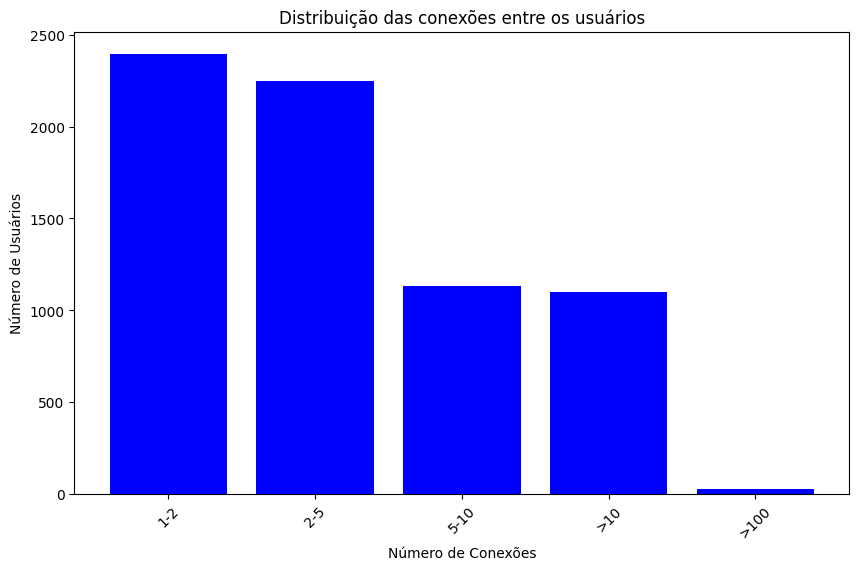

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the number of connections for each user
# Since it's a directed graph, consider both in and out edges
connections = {node: len(list(G.neighbors(node))) + len(list(G.predecessors(node))) for node in G.nodes()}

# Categorize users based on connection ranges
categories = {'1-2': 0,
              '2-5': 0,
              '5-10': 0,
              '>10': 0,
              '>100': 0}

for count in connections.values():
    if 1 <= count <= 2:
        categories['1-2'] += 1
    elif 3 <= count <= 5:
        categories['2-5'] += 1
    elif 6 <= count <= 10:
        categories['5-10'] += 1
    elif 11 <= count <= 100:
        categories['>10'] += 1
    else:
        categories['>100'] += 1

# Plot the data in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories.keys(), categories.values(), color='blue')
plt.xlabel('Número de Conexões')
plt.ylabel('Número de Usuários')
plt.title('Distribuição das conexões entre os usuários')
plt.xticks(rotation=45)
plt.show()


In [ ]:
#best community detection algo for Directed Graphs. the other ones might be bugged
communities_summary = analyze_communities(G, algorithm="leiden", resolution=5, algo=leidenalg.RBConfigurationVertexPartition)
print(f"Number of communities: {communities_summary['number_of_communities']}")
print(f"Largest community has {communities_summary['largest_community_size']} nodes.")
print(f"Smallest community has {communities_summary['smallest_community_size']} nodes.")
print(f"Average community size: {communities_summary['average_community_size']:.2f}")
print(f"Modularity score: {communities_summary['modularity_score']:.4f}")
network_communities = communities_summary["communities"]
set_node_modularity_class(G,network_communities,False)

Number of communities: 61
Time taken: 3.24 seconds


Number of communities: 61
Largest community has 50 nodes.
Smallest community has 3 nodes.
Average community size: 32.10
Modularity score: 0.5337


In [ ]:
community = network_communities[0]
ecc = calculate_community_ecc(G, community)
gec = calculate_community_gec(G, community)
ae = calculate_community_exposure(community)
homogeneity = calculate_community_homogeneity(G, community)
print(f"Community {community} : ECC={ecc}, GEC={gec}, Homogeneity={homogeneity}, Average Exposure={ae}")

Community ['112275', '59389', '161698', '164961', '43389', '150053', '125347', '139366', '162917', '189209', '125369', '210361', '119556', '235632', '130005', '314855', '125386', '204404', '175155', '180018', '43354', '165754', '59839', '78606', '126181', '679679', '436652', '194062', '210992', '977062', '110967', '49634', '130163', '135887', '164417', '163682', '45578', '135549', '113931', '64091', '131046', '162200', '119173', '181418', '166953', '948160', '115392', '149273', '159690', '150074'] : ECC=0.5683214913905997, GEC=-53.0, Homogeneity=0.26414634146341465, Average Exposure=0.07454545454545453


In [ ]:
metrics = []

for idx, community in enumerate(network_communities):
    ecc = calculate_community_ecc(G, community)
    gec = calculate_community_gec(G, community)
    homogeneity = calculate_community_homogeneity(G, community)
    ae = calculate_community_exposure(community)

    # Armazenar os resultados no objeto metrics
    metrics.append({
        'ecc': ecc,
        'gec': gec,
        'homogeneity': homogeneity,
        'average_exposure': ae
    })

    print(f"Community ID {idx}: ECC={ecc}, GEC={gec}, Homogeneity={homogeneity}, Average Exposure={ae}")


Community ID 0: ECC=0.5683214913905997, GEC=-53.0, Homogeneity=0.26414634146341465, Average Exposure=0.07454545454545453
Community ID 1: ECC=0.4432586443834803, GEC=-92.0, Homogeneity=0.326046511627907, Average Exposure=0.053750000000000006
Community ID 2: ECC=0.3019515747025034, GEC=-562.0, Homogeneity=0.23035422343324252, Average Exposure=0.09061728395061727
Community ID 3: ECC=0.36176753039616444, GEC=-74.0, Homogeneity=0.34178571428571425, Average Exposure=0.06588235294117646
Community ID 4: ECC=0.49919866616850334, GEC=-57.0, Homogeneity=0.3232227488151659, Average Exposure=0.08115384615384615
Community ID 5: ECC=0.4299963680518402, GEC=-186.0, Homogeneity=0.323610473128158, Average Exposure=0.09333733493397355
Community ID 6: ECC=0.53275811181118, GEC=-29.0, Homogeneity=0.26967120181405896, Average Exposure=0.06931074316519067
Community ID 7: ECC=0.3176149362109955, GEC=-249.0, Homogeneity=0.23375640008653636, Average Exposure=0.09167476514415286
Community ID 8: ECC=0.37124158918

Community ID 0: ECC=0.5683214913905997, GEC=-0.08731466227347612, Homogeneity=0.26414634146341465, Average Exposure=0.07454545454545453
Community ID 1: ECC=0.4432586443834803, GEC=-0.1515650741350906, Homogeneity=0.326046511627907, Average Exposure=0.053750000000000006
Community ID 2: ECC=0.3019515747025034, GEC=-0.9258649093904449, Homogeneity=0.23035422343324252, Average Exposure=0.09061728395061727
Community ID 3: ECC=0.36176753039616444, GEC=-0.12191103789126853, Homogeneity=0.34178571428571425, Average Exposure=0.06588235294117646
Community ID 4: ECC=0.49919866616850334, GEC=-0.09390444810543658, Homogeneity=0.3232227488151659, Average Exposure=0.08115384615384615
Community ID 5: ECC=0.4299963680518402, GEC=-0.30642504118616143, Homogeneity=0.323610473128158, Average Exposure=0.09333733493397355
Community ID 6: ECC=0.53275811181118, GEC=-0.047775947281713346, Homogeneity=0.26967120181405896, Average Exposure=0.06931074316519067
Community ID 7: ECC=0.3176149362109955, GEC=-0.410214

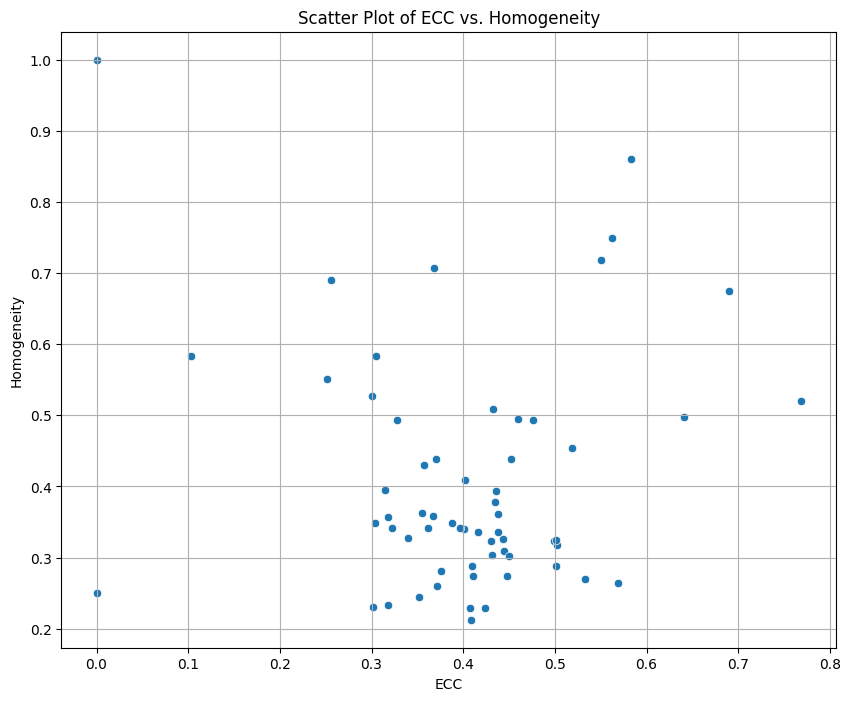

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponha que metrics seja a lista que contém as métricas de cada comunidade
data = {
    'ECC': [entry['ecc'] for entry in metrics],
    'GEC': [entry['gec'] for entry in metrics],
    'Homogeneity': [entry['homogeneity'] for entry in metrics],
    'Average Exposure': [entry['average_exposure'] for entry in metrics]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='ECC', y='Homogeneity', data=df)
plt.title('Scatter Plot of ECC vs. Homogeneity')
plt.xlabel('ECC')
plt.ylabel('Homogeneity')
plt.grid(True)
plt.show()



In [ ]:
import plotly.graph_objects as go
# Obter todas as comunidades
community_names = [f"Community {i}" for i in range(len(metrics))]

# Calcular os valores mínimos e máximos de todas as métricas
all_values = [value for community in metrics for key, value in community.items()]
min_value = min(all_values)
max_value = max(all_values)

# Criar o gráfico
fig = go.Figure()

for metric_name in metrics[0].keys():
    fig.add_trace(go.Scatterpolar(
        r=[community[metric_name] for community in metrics],
        theta=community_names,
        fill='none',
        name=metric_name,
        hoverinfo="theta+r",
        hovertext=[f"{metric_name}: {community[metric_name]}" for community in metrics]
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-1,1]
        )),
    showlegend=True
)

fig.show()